# Reproduce and train Rec-CNN

This model was describe in the following paper : Araya Kibrom Desta, Shuji Ohira, Ismail Arai, Kazutoshi Fujikawa, Rec-CNN: In-vehicle networks intrusion detection using convolutional neural networks trained on recurrence plots, Vehicular Communications, Volume 35, 2022, 100470, ISSN 2214-2096, [doi.org/10.1016/j.vehcom.2022.10047](https://doi.org/10.1016/j.vehcom.2022.100470). (https://www.sciencedirect.com/science/article/pii/S2214209622000171).

The dataset used for train the model came from : <https://ocslab.hksecurity.net/Datasets/car-hacking-dataset>

The code is written by me.

## Setup

```bash
uv sync --dev
```

### Import

In [ ]:
import pathlib

try:
    from google.colab import drive

    drive.mount("/content/drive", force_remount=True)
    STORAGE = pathlib.Path("/content/drive/MyDrive") / "data"
except ImportError:
    STORAGE = pathlib.Path() / "data"
STORAGE.mkdir(parents=True, exist_ok=True)

Mounted at /content/drive


In [ ]:
import csv
import pickle
import random
import re
import shutil
import urllib.request
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import Model, Sequential, saving
from keras.api.callbacks import EarlyStopping, ModelCheckpoint
from keras.api.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPooling2D,
)
from keras.api.optimizers import Nadam
from keras.api.optimizers.schedules import ExponentialDecay
from keras.api.utils import image_dataset_from_directory
from PIL import Image
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sklearn.preprocessing import OrdinalEncoder
from tqdm.auto import tqdm

### Constants

In [ ]:
CACHE = pathlib.Path(".cache").resolve()
DATASET = STORAGE / "dataset"
IMAGES = CACHE / "images"
BATCH_SIZE = 128
CHUNK_SIZE = 524_288
SEED = 42
LIMIT = 80_000
BENIGN = "Benign"
print(CACHE)

/content/.cache


## Preprocess

In [ ]:
def download_dataset() -> None:
    """Download the dataset.

    Page:
        https://ocslab.hksecurity.net/Datasets/car-hacking-dataset
    """
    marker = DATASET / "download_finished"
    if marker.exists():
        print("Already downloaded !")
        return
    shutil.rmtree(DATASET, ignore_errors=True)
    DATASET.mkdir(parents=True, exist_ok=True)
    response = urllib.request.urlopen(
        "https://www.dropbox.com/sh/rla5e764f9zhr0b/AABn24F8KaXMPH7QaNlXSAHea?st=b7r7855u&dl=1"
    )
    total_size = int(response.getheader("Content-Length", 0))
    destination = DATASET / "Car-Hacking-Dataset.zip"
    with (
        destination.open("wb") as dest_file,
        tqdm(
            total=total_size,
            unit="B",
            unit_scale=True,
            desc=destination.name,
        ) as progress_bar,
    ):
        while chunk := response.read(CHUNK_SIZE):
            dest_file.write(chunk)
            progress_bar.update(len(chunk))
    with zipfile.ZipFile(destination, "r") as archive:
        for member in archive.namelist():
            if member == "/":  # Skip root
                continue
            print(f"Extract {member!r}")
            file_path = (DATASET / member).resolve()
            if file_path.exists():
                continue
            if not file_path.is_relative_to(DATASET):
                err_message = f"Unsafe file path detected: {file_path}"
                raise ValueError(err_message)
            archive.extract(member, DATASET)
    marker.touch()


download_dataset()

Already downloaded !


In [ ]:
RE_GIDS_LOG = re.compile(
    r"Timestamp: (?P<timestamp>[\d\.]+)\s+ID: (?P<id>\w+).*"
    r"DLC: (?P<dlc>\d)\s+(?P<hex>(?:\w{2}\s*){1,8})"
)


def gids_normal_run_txt_to_csv() -> None:
    """Parses the GIDS dataset, extracts CAN IDs, payloads, and encoding.

    :param file_path: Path to the log file containing CAN messages.
    :param num_classes: Number of unique CAN IDs for One-Hot Encoding.
    :return: Tuple containing (feature tensors, labels).
    """
    path = DATASET / "normal_run_data" / "normal_run_data.txt"
    dest = DATASET / "normal_dataset.csv"
    if dest.exists():
        return
    with dest.open("w", encoding="utf-8") as stream:
        writer = csv.writer(stream, lineterminator="\n")
        with pathlib.Path(path).open("rt", encoding="utf-8") as file:
            lines = file.read().strip().splitlines()[:-1]
            for line in tqdm(lines, desc="Convert normal_run_data.txt to CSV"):
                # Extract CAN ID and Payload using regex
                match = RE_GIDS_LOG.search(line)
                if match:
                    timestamp = match["timestamp"]
                    frame_id = match["id"]
                    dlc = int(match["dlc"], 16)
                    payload = match.group("hex").strip().split()
                    row = [timestamp, frame_id, dlc, *payload, "R"]
                    writer.writerow(row)


gids_normal_run_txt_to_csv()

In [ ]:
def load_dataset(path: pathlib.Path, klass: str) -> pd.DataFrame:
    print(f"Loading {path.name}")
    df = pd.read_csv(path, header=None, usecols=range(12))
    df = df.set_axis(
        [
            "Timestamp",
            "Arbitration_ID",
            "DLC",
            "DATA_0",
            "DATA_1",
            "DATA_2",
            "DATA_3",
            "DATA_4",
            "DATA_5",
            "DATA_6",
            "DATA_7",
            "Label",
        ],
        axis=1,
    )
    df["Class"] = BENIGN
    df.loc[df["Label"] == "T", "Class"] = klass

    # Fix bad parsing
    for i in range(7, -1, -1):
        row_indexer = df["DLC"] == i
        df.loc[row_indexer, "Label"] = df.loc[row_indexer, f"DATA_{i}"]
        df.loc[row_indexer, f"DATA_{i}"] = np.nan
    return df


# Load dataset
DOS = load_dataset(DATASET / "DoS_dataset.csv", "Dos")
FUZZY = load_dataset(DATASET / "Fuzzy_dataset.csv", "Fuzzy")
GEAR = load_dataset(DATASET / "gear_dataset.csv", "Gear")
RPM = load_dataset(DATASET / "RPM_dataset.csv", "RPM")
FULL_NORMAL = load_dataset(DATASET / "normal_dataset.csv", "Attack")

# Create and save encoder
id_encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)
id_encoder.fit(FULL_NORMAL[["Arbitration_ID"]])
pickle.dump(id_encoder, (STORAGE / "encoder-Rec-CNN.pickle").open("wb"))

# Add Unique_ID to dataset
DOS["Unique_ID"] = id_encoder.transform(DOS[["Arbitration_ID"]])
FUZZY["Unique_ID"] = id_encoder.transform(FUZZY[["Arbitration_ID"]])
GEAR["Unique_ID"] = id_encoder.transform(GEAR[["Arbitration_ID"]])
RPM["Unique_ID"] = id_encoder.transform(RPM[["Arbitration_ID"]])
FULL_NORMAL["Unique_ID"] = id_encoder.transform(
    FULL_NORMAL[["Arbitration_ID"]]
)

# Split benign dataset in three
BENIGN_RANDOM_RPM = FULL_NORMAL[: LIMIT - 9000].reset_index(drop=True)
NORMAL = FULL_NORMAL[LIMIT : LIMIT * 6].reset_index(
    drop=True
)  # We keep the other part for attack
ATTACK = FULL_NORMAL[LIMIT * 6 :].reset_index(drop=True)

# Load benign attack for DRL
print(f"benign.parquet.br shape {ATTACK.shape}")
ATTACK.to_parquet(STORAGE / "benign.parquet.br", index=False)

Loading DoS_dataset.csv
Loading Fuzzy_dataset.csv
Loading gear_dataset.csv
Loading RPM_dataset.csv
Loading normal_dataset.csv
benign.parquet.br shape (508871, 14)


In [ ]:
line = RPM[RPM["Class"] != "Benign"].head(1)
line["Class"] = "RandomRPM"
morsels = []
gen = random.Random(SEED)
length = BENIGN_RANDOM_RPM.shape[0]
current = 0
for i in tqdm(range(length + 1)):
    attack_probability = (i / length) * 0.2
    act_attack = gen.random() < attack_probability
    if act_attack:
        morsel = BENIGN_RANDOM_RPM.iloc[current:i]
        morsels.append(morsel)
        current = i
        timestamp = morsel.iloc[-1]["Timestamp"]
        attack = line.copy()
        attack["Timestamp"] = timestamp
        morsels.append(attack)
morsels.append(BENIGN_RANDOM_RPM.iloc[current:])
RANDOM_RPM = pd.concat(morsels, ignore_index=True).reset_index(drop=True)
print(f"morsels: {len(morsels)}")
print(f"RANDOM_RPM shape: {RANDOM_RPM.shape}")
RANDOM_RPM = RANDOM_RPM[:LIMIT]
print(f"reshaped RANDOM_RPM shape: {RANDOM_RPM.shape}")
display(RANDOM_RPM.head(10))
display(RANDOM_RPM.tail(10))

  0%|          | 0/71001 [00:00<?, ?it/s]

morsels: 14475
RANDOM_RPM shape: (78237, 14)
reshaped RANDOM_RPM shape: (78237, 14)


,Timestamp,Arbitration_ID,DLC,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,Label,Class,Unique_ID
0,1.479121e+09,0350,8,05,28,84,66,6d,00,00,a2,R,Benign,15.0
1,1.479121e+09,02c0,8,14,00,00,00,00,00,00,00,R,Benign,12.0
2,1.479121e+09,0430,8,00,00,00,00,00,00,00,00,R,Benign,17.0
3,1.479121e+09,04b1,8,00,00,00,00,00,00,00,00,R,Benign,20.0
4,1.479121e+09,01f1,8,00,00,00,00,00,00,00,00,R,Benign,8.0
5,1.479121e+09,0153,8,00,00,00,ff,00,ff,00,00,R,Benign,6.0
6,1.479121e+09,0002,8,00,00,00,00,00,00,00,0a,R,Benign,0.0
7,1.479121e+09,018f,8,fe,36,00,00,00,3c,00,00,R,Benign,7.0
8,1.479121e+09,0130,8,03,80,00,ff,21,80,00,9d,R,Benign,3.0
9,1.479121e+09,0131,8,00,80,00,00,2d,7f,00,97,R,Benign,4.0


,Timestamp,Arbitration_ID,DLC,DATA_0,DATA_1,DATA_2,DATA_3,DATA_4,DATA_5,DATA_6,DATA_7,Label,Class,Unique_ID
78227,1.479121e+09,043f,8,02,45,60,ff,5b,17,17,00,R,Benign,18.0
78228,1.479121e+09,0370,8,00,23,00,00,00,00,00,00,R,Benign,16.0
78229,1.479121e+09,0440,8,ff,02,13,00,ff,17,17,76,R,Benign,19.0
78230,1.479121e+09,02c0,8,14,00,00,00,00,00,00,00,R,Benign,12.0
78231,1.479121e+09,0350,8,05,28,d4,66,6c,00,00,f3,R,Benign,15.0
78232,1.479121e+09,0430,8,00,00,00,00,00,00,00,00,R,Benign,17.0
78233,1.479121e+09,0316,8,45,29,24,ff,29,24,00,ff,T,RandomRPM,13.0
78234,1.479121e+09,04b1,8,6f,4a,b5,94,00,00,00,02,R,Benign,20.0
78235,1.479121e+09,0316,8,45,29,24,ff,29,24,00,ff,T,RandomRPM,13.0
78236,1.479121e+09,01f1,8,00,c8,a4,10,0a,a4,20,0a,R,Benign,8.0


In [ ]:
ALL = {
    "DOS": DOS,
    "FUZZY": FUZZY,
    "GEAR": GEAR,
    "RPM": RPM,
    "RANDOM_RPM": RANDOM_RPM,
}

In [ ]:
def recurrence_plot(
    s: npt.NDArray[np.int8],
) -> npt.NDArray[np.int8]:
    distance_matrix = s[None, :] - s[:, None]
    return np.rot90(np.array(distance_matrix != 0, dtype=np.int8))


def generate_recurrence_plots(
    df: pd.DataFrame, limit: int, attack: bool = False
) -> None:
    """Preprocess datasets."""
    # Convert CAN ID frames to recurrent plots
    # Total params 534,225
    if attack:
        filter_indices = df["Class"] != BENIGN
        folder = "Attack"
    else:
        filter_indices = df["Class"] == BENIGN
        folder = "Benign"
    all_indices = df.loc[filter_indices].index
    indices_without_max = all_indices[all_indices >= BATCH_SIZE]
    random_indices = np.random.choice(indices_without_max, limit).tolist()
    for i in tqdm(
        random_indices,
        unit_scale=True,
        desc="Process recurrence plots",
        smoothing=0.01,
    ):
        chunk = df.iloc[i - BATCH_SIZE + 1 : i + 1]  # i + 1 = keep until i
        klass = chunk["Class"].iloc[BATCH_SIZE - 1]
        seq = chunk["Unique_ID"].to_numpy()
        img = recurrence_plot(seq)
        new_image = Image.fromarray(img, "L")
        path = IMAGES / folder / f"{klass}-{i:09}.png"
        path.parent.mkdir(parents=True, exist_ok=True)
        new_image.save(path)


marker_images = CACHE / "marker_images"
if not marker_images.exists():
    np.random.seed(SEED)
    shutil.rmtree(IMAGES, ignore_errors=True)
    print("Process benign samples")
    generate_recurrence_plots(NORMAL, LIMIT * 5, attack=False)
    for name, df in ALL.items():
        print(f"Process dataset {name}")
        generate_recurrence_plots(df, LIMIT, attack=True)
    marker_images.touch()
np.random.seed(SEED)

Process benign samples


Process recurrence plots:   0%|          | 0.00/400k [00:00<?, ?it/s]

Process dataset DOS


Process recurrence plots:   0%|          | 0.00/80.0k [00:00<?, ?it/s]

Process dataset FUZZY


Process recurrence plots:   0%|          | 0.00/80.0k [00:00<?, ?it/s]

Process dataset GEAR


Process recurrence plots:   0%|          | 0.00/80.0k [00:00<?, ?it/s]

Process dataset RPM


Process recurrence plots:   0%|          | 0.00/80.0k [00:00<?, ?it/s]

Process dataset RANDOM_RPM


Process recurrence plots:   0%|          | 0.00/80.0k [00:00<?, ?it/s]

In [ ]:
print(len(list(IMAGES.glob("**/*.png"))))

558977


/content/.cache/images/Benign/Benign-000019768.png
(128, 128)


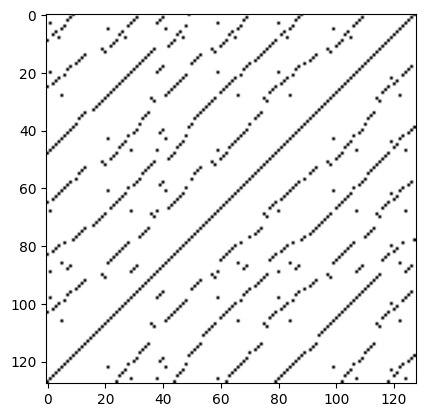

In [ ]:
import matplotlib.image as mpimg

for path in (IMAGES / "Benign").glob("**/*.png"):
    print(path)
    img1 = mpimg.imread(path)
    plt.imshow(img1, cmap="gray")
    print(img1.shape)
    plt.show()
    break

In [ ]:
def process(image, label):
    image = tf.cast(image / 255.0, tf.float32)
    return image, label


train_dataset = image_dataset_from_directory(
    IMAGES,
    validation_split=0.1,
    subset="training",
    seed=SEED,
    image_size=(128, 128),
    batch_size=BATCH_SIZE,
)
# train_dataset = train_dataset.map(process)

validation_dataset = image_dataset_from_directory(
    IMAGES,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    image_size=(128, 128),
    batch_size=BATCH_SIZE,
)
# validation_dataset = validation_dataset.map(process)

Found 558977 files belonging to 2 classes.
Using 503080 files for training.
Found 558977 files belonging to 2 classes.
Using 55897 files for validation.


## Models

### Binary classifier

In [ ]:
def create_binary_classifier() -> Model:
    """Builds a CNN for binary classification (benign vs anomaly).

    Architecture:
      1) Conv2D(64, 3x3, same, ReLU) -> MaxPool(2x2)
      2) Conv2D(16, 3x3, same, ReLU) -> MaxPool(2x2)
      3) Dropout(0.9)
      4) Flatten()
      5) Dense(32, ReLU)
      6) Dense(1, Sigmoid)

    Returns:
        A compiled keras.Model ready for training.
    """
    model = Sequential(
        [
            Input(shape=(128, 128, 3)),
            Conv2D(64, (3, 3), padding="same", activation="relu"),
            MaxPooling2D((2, 2)),
            Conv2D(16, (3, 3), padding="same", activation="relu"),
            MaxPooling2D((2, 2)),
            Dropout(0.9),
            Flatten(),
            Dense(32, activation="relu"),
            Dense(1, activation="sigmoid"),
        ]
    )

    lr_schedule = ExponentialDecay(
        initial_learning_rate=1e-4,
        decay_steps=1000,
        decay_rate=0.1,
    )

    model.compile(
        optimizer=Nadam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


# 534,225
print("Creating binary classifier...")
binary_model = create_binary_classifier()
binary_model.summary()

Creating binary classifier...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       524,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 535,377 (2.04 MB)

 Trainable params: 535,377 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", patience=3, verbose=1, mode="auto"
)
model_checkpoint = ModelCheckpoint(
    filepath=STORAGE / "Rec-CNN.keras",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True,
    mode="auto",
)


history = binary_model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=validation_dataset,
    validation_steps=len(validation_dataset),
    epochs=343,
    verbose=1,
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/343
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9824 - loss: 0.0435
Epoch 1: val_accuracy improved from -inf to 0.99716, saving model to /content/drive/MyDrive/data/Rec-CNN.keras
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 73s 17ms/step - accuracy: 0.9824 - loss: 0.0435 - val_accuracy: 0.9972 - val_loss: 0.0107
Epoch 2/343
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9969 - loss: 0.0123
Epoch 2: val_accuracy did not improve from 0.99716
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.9969 - loss: 0.0123 - val_accuracy: 0.9972 - val_loss: 0.0107
Epoch 3/343
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9969 - loss: 0.0126
Epoch 3: val_accuracy did not improve from 0.99716
3931/3931 ━━━━━━━━━━━━━━━━━━━━ 60s 15ms/step - accuracy: 0.9969 - loss: 0.0126 - val_accuracy: 0.9972 - val_loss: 0.0107
Epoch 4/343
3927/3931 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9969 - loss: 0.0123
Epoch 4: val_accuracy did not improve from 0.99716
3931/3931 ━━━

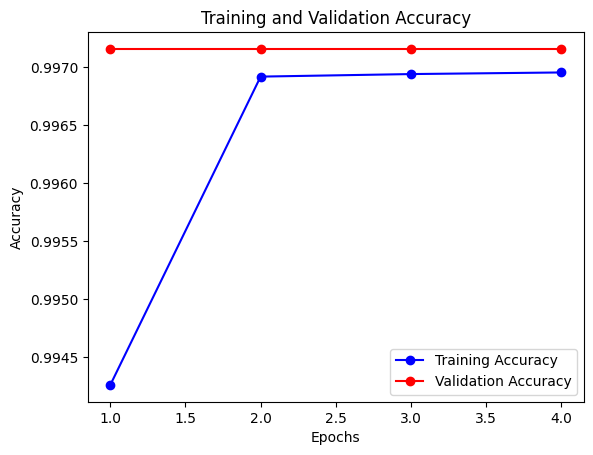

In [ ]:
training_accuracy = history.history["accuracy"]
validation_accuracy = history.history.get("val_accuracy")

epochs = range(1, len(training_accuracy) + 1)
plt.plot(epochs, training_accuracy, "bo-", label="Training Accuracy")
if validation_accuracy:
    plt.plot(epochs, validation_accuracy, "ro-", label="Validation Accuracy")

plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Test model

In [ ]:
# Generate array
y_true_arr = []
x_arr = []
i = 0
for x, y in validation_dataset:
    y_true_arr.append(y.numpy())
    x_arr.append(x.numpy())
    i += 1
    if i == 10_000:
        break

# Concatenate batches into arrays
x = np.concatenate(x_arr)
y_true = np.concatenate(y_true_arr)
del x_arr, y_true_arr

In [ ]:
# Load or use your trained model
model: Sequential = saving.load_model(STORAGE / "Rec-CNN.keras")

# Get predictions
y_pred_probs = model.predict(x)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
display("".join(str(i) for i in y_true[:100]))
display("".join(str(i) for i in y_pred[:100]))

1747/1747 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step


'0010001110100001111011010010010000101010100111111100001111101101001110001000011010001001111000101101'

'0010001110100001111011010010010000101010100111111100001111101101001110001000011010001001111000101101'

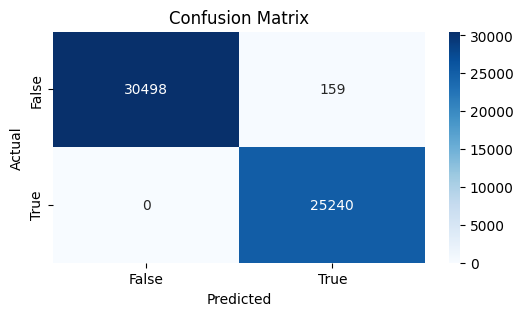


Classification Report:
              precision    recall  f1-score   support

       False     1.0000    0.9948    0.9974     30657
        True     0.9937    1.0000    0.9969     25240

    accuracy                         0.9972     55897
   macro avg     0.9969    0.9974    0.9971     55897
weighted avg     0.9972    0.9972    0.9972     55897

FPR = 0.005186417457676876
FNR = 0.0
TPR = 0.9948135825423231
TNR = 1.0


In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 3))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["False", "True"],
    yticklabels=["False", "True"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
TN, FP, FN, TP = cm.ravel()
false_positive_ratio = FP / (FP + TN)
false_negative_ratio = FN / (FN + TP)
true_positive_ratio = 1 - false_positive_ratio
true_negative_ratio = 1 - false_negative_ratio

print("\nClassification Report:")
print(
    classification_report(
        y_true, y_pred, target_names=["False", "True"], digits=4
    )
)
print("FPR", "=", false_positive_ratio)
print("FNR", "=", false_negative_ratio)
print("TPR", "=", true_positive_ratio)
print("TNR", "=", true_negative_ratio)